# Evaluate commuter data over time
The code below takes labbeled data, trains a model with a growing amount of training.
Since this is done itaratively and compared to predictions towards a test set an estimation can be made over how fast the model converges.


In [1]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *

#print(df)path="data"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]
user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn

def predict_journeys(learner,dataset):  
    "Return"
    result = 0
    accuracy = 0
    for x in range(0,dataset.shape[0]):
        correct = dataset.iloc[x].journey  #remove journey
        predicted = learner.predict(dataset.iloc[x],pbar=None);
        if (correct==predicted[0]):
            result=result+1
    accuracy=result/dataset.shape[0]
    return(accuracy)
    
def predict_journey(detectedActivity,geoHash,minuteOfday,weekday):
    data = np.array([['','detectedActivity','geoHash','minuteOfDay','weekday'],
                ["row1",detectedActivity,geoHash,minuteOfday,weekday]])            
    dr=pd.DataFrame(data=data[1:,1:],
                    index=data[1:,0],
                    columns=data[0,1:]).astype(np.int64)
    predicted = learner.predict(dr.iloc[0])
    return(predicted[0],str(round(predicted[2].max().item(),2)))

def evaluate_learner(rows_per_training:int,trainingset,testset,minsize=20): #Minimal start for any training can bne used for offset
    #dataSet = pd.read_csv("data/"+filename,comment="-")
    #datasetTest = pd.read_csv("data/"+testfilename,comment="-")
    result = []
    if trainingset.shape[0]<minsize or testset.shape[0]<minsize:
        trainingset = pd.concat([trainingset,trainingset])
    #size=trainingset.shape[0]
    for rows in range(minsize,len(trainingset),rows_per_training):
        #df=trainingset[rows-rows_per_training:rows]
        df=trainingset[0:rows]
        idx= list(np.random.randint(0,len(df),int(len(df)*0.1)))
        data = (TabularList.from_df(df, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(idx)
                .label_from_df(cols=dep_var)
                .databunch())
        learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
        learner.fit_one_cycle(30)
        #learner.fit(5, 1e-2)
        sizeR = len(learner.recorder.metrics)
#        epochs=5  
#         while learner.recorder.metrics[sizeR-1][0].item()<0.95 and epochs<30:
#             learner.fit_one_cycle(epochs)
#             epochs=epochs+1
        #run on testset
        resultTest = predict_journeys(learner,testset)
        result.append([rows,learner.recorder.metrics[sizeR-1][0].item(),resultTest])
    return (result)


In [15]:
evaluate_learner2("rrr")

'Jepp'

### How fast in weeks do we get acceptable accuracy (Incremental training (That did not turn out well))
https://forums.fast.ai/t/does-learn-fit-learn-incrementally-every-time-we-call-it/18566

Below we train models incrementally for each week, based on an estimate number of rows that will be saved for each week (totalrows in dataset/52). 
For this we start from an idelised dataset covering one year of use dataset of the commuter app. The trained model is for every weeks trainng evaluated towards a static test set. 
This test set has the same distribution as the training set and the result is ploted over time 
Deviations compared to a dataset created if the app has been used in reality:
* Training data only includes relevant searches that is part of the users scenarios.
* Test set only includes correct test data.


In [17]:
%%capture
#Training without teaching set
trainingset = pd.read_csv("data/"+user+"_train_valid.csv")
#Take 14 days
trainingset=trainingset[0:int(trainingset.shape[0]/24)]
testset = pd.read_csv("data/"+user+"_test.csv")
size=trainingset.shape[0]
rows_per_training = int(size/14) # will result in about one training per day
print(rows_per_training)
print(len(trainingset))
resultTrain = evaluate_learner(rows_per_training,trainingset,testset,20)

In [2]:
%%capture
#Training with teaching set 
trainingset = pd.read_csv("data/"+user+"_train_valid.csv")
#Take first two weeks
trainingset=trainingset[0:int(trainingset.shape[0]/24)]
teachingset = pd.read_csv("data/"+user+"_teaching_set.csv")
fram = [teachingset,teachingset,teachingset,teachingset] #data agumentation :)
teachingset = pd.concat(fram)
frames = [teachingset,trainingset]
trainingset2 = pd.concat(frames)
testset = pd.read_csv("data/"+user+"_test.csv")
size=trainingset.shape[0]
rows_per_training = int(size/14) # will result in amount of rows for one day training per day
print(rows_per_training)
print(len(trainingset2))
print(len(trainingset))
print(len(teachingset))
resultTeach = evaluate_learner(rows_per_training,trainingset2,testset,len(teachingset))

254
18
range(0, 254, 18)


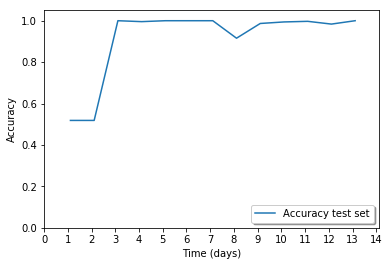

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
result = np.array(resultTrain)
##MT
#size = trainingset2.shape[0]
#teachingsize = teachingset.shape[0]
#ML
size = trainingset.shape[0]
teachingsize=0

fig, ax = plt.subplots()
#ax.plot(result[:,0]-teachingsize,result[:,1],label='Accuracy train')
ax.plot(result[:,0]-teachingsize,result[:,2],label='Accuracy test set')
plt.xlabel('Time (days)')
plt.ylabel('Accuracy')
ax.axis([0,size-teachingsize,0.0,1.05])
print(size)
print(rows_per_training)
ax.set_xticks(np.arange(0, size-teachingsize, rows_per_training))
xs = range(0,size-teachingsize,rows_per_training)
print(xs)
def format_fn(tick_val, tick_pos):
    if int(tick_val) in xs:
        return int(tick_val/rows_per_training)
    else:
         return ''
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

In [21]:
without_MT = result.copy()
print(without_MT)


[[ 20.         1.         0.518519]
 [ 38.         1.         0.518519]
 [ 56.         1.         1.      ]
 [ 74.         1.         0.995556]
 [ 92.         1.         1.      ]
 [110.         1.         1.      ]
 [128.         1.         1.      ]
 [146.         1.         0.915556]
 [164.         1.         0.986667]
 [182.         1.         0.994074]
 [200.         1.         0.997037]
 [218.         0.952381   0.983704]
 [236.         0.956522   1.      ]]


### Teaching
If an idealised teaching set is created that contains all combinations of categorical columns (activity and weekday) combined with a time placed in the middle of the timespan for the scenario and location at the departure station.

Total time: 00:11
epoch  train_loss  valid_loss  accuracy
1      1.681446    1.782976    0.076923  (00:00)
2      1.535593    1.762603    0.346154  (00:00)
3      1.386754    1.727212    0.730769  (00:00)
4      1.251965    1.670756    0.576923  (00:00)
5      1.132818    1.582242    0.653846  (00:00)
6      1.021589    1.464285    0.692308  (00:00)
7      0.921434    1.311666    0.692308  (00:00)
8      0.830203    1.129243    0.961538  (00:00)
9      0.742522    0.943380    0.961538  (00:00)
10     0.680387    0.804802    0.961538  (00:00)
11     0.606011    0.596288    1.000000  (00:00)
12     0.542104    0.433281    1.000000  (00:00)
13     0.491892    0.346342    1.000000  (00:00)
14     0.448149    0.307558    1.000000  (00:00)
15     0.404295    0.251588    1.000000  (00:00)
16     0.366778    0.337410    1.000000  (00:00)
17     0.331841    0.212240    1.000000  (00:00)
18     0.301378    0.110999    1.000000  (00:00)
19     0.274170    0.071583    1.000000  (00:00)
20     0.25

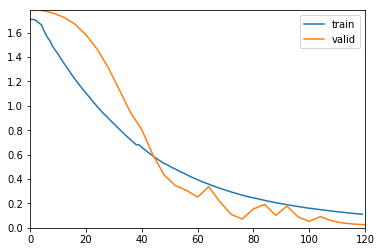

In [23]:
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filename = user+"_teaching_set.csv"
teachingSet = pd.read_csv("data/"+filename)
fram = [teachingSet,teachingSet,teachingSet,teachingSet]
print(len(teachingSet))
teachingSet = pd.concat(fram)
print(len(teachingSet))
#idx = np.random.randint(0,len(dataSet),int(len(dataSet)*0.1))
idx = list(np.random.randint(0,len(teachingSet),int(len(teachingSet)*0.1)))
#idx= list(np.random.randint(0,len(dataSet),2))
#rows=teachingSet.shape[0]
data = (TabularList.from_df(teachingSet, path="saved", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(idx)
                .label_from_df(cols=dep_var)
                #.add_test(datasetTest)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy, callback_fns=ShowGraph)
learner.fit_one_cycle(30)
#epochs = 4
# while learner.recorder.metrics[sizeR-1][0].item()<0.7 and epochs<30:
#             learner.fit_one_cycle(epochs)
#             epochs=epochs+1
#learner.save(user)
#data.export()

If we avaluate this on the test set

In [26]:
%%capture
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
filenameTest = user+"_test.csv"
datasetTest = pd.read_csv("data/"+filenameTest)
accuracyTest = predict_journeys(learner,datasetTest)

Print result

In [27]:
print(accuracyTest)

0.0


In [5]:
prediction,accuracy = predict_journey(3,1242479403,519,3)
print("Predicted journey from: "+str(prediction)[0:5]+" to " +str(prediction)[5:10]+ " with accuracy "+str(accuracy));

Predicted journey from: 81216 to 80000 with accuracy 0.59


Predict and view some rows

### Misc

### Training on parts of data


Run test one cycle with part of the training set.

Total time: 00:02
epoch  train_loss  valid_loss  accuracy
1      0.033034    0.074282    1.000000  (00:00)
2      0.049107    0.007821    1.000000  (00:00)
3      0.058257    0.301398    0.830000  (00:00)
4      0.040668    0.113533    0.990000  (00:00)
5      0.031681    0.520180    0.640000  (00:00)



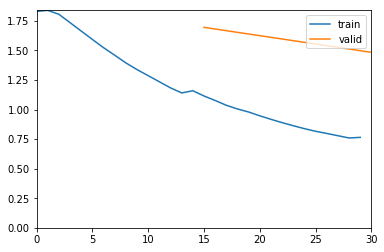

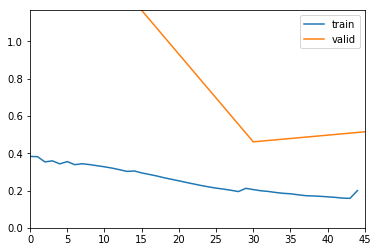

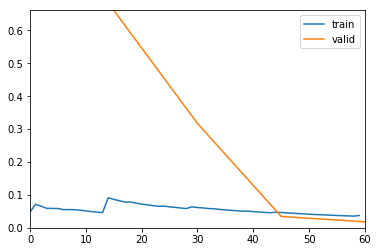

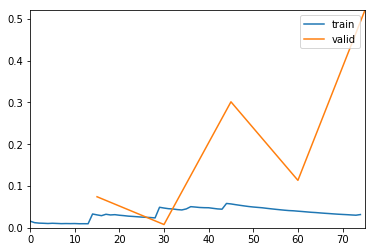

In [11]:
filename = user+"_train_valid.csv"
dataSetIn = pd.read_csv("data/"+filename)
dataSet=dataSetIn[0:1000]
rows=dataSet.shape[0]
idx= list(np.random.randint(0,len(dataSet),int(len(dataSet)*0.1)))
#idx=list(range(2000,4000))
data = (TabularList.from_df(dataSet, path="models", cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
#%time learner.fit_one_cycle(10)
learner.fit_one_cycle(2)
epochs = 3
sizeR = len(learner.recorder.metrics)
while learner.recorder.metrics[sizeR-1][0].item()<0.95 and epochs<30:
            learner.fit_one_cycle(epochs)
            epochs=epochs+1
#%time learner.fit_one_cycle(5)
#%time learner.fit(10, 1e-2)
#testSet = pd.read_csv("data/testWithLabels.csv",comment="-")
#resultTest = predict_journeys(learner,testSet)

In [9]:
#learner.metrics[0]
#dataSet.sample(3)
#list(np.random.randint(0,len(dataSet),10))
#list(range(0,20))
#int(len(dataSet)*0.1)
#len(dataSet)
#data
#preds,y,losses = learner.get_preds(with_loss=True)
#interp = ClassificationInterpretation(data, preds, y, losses)
sizeR = len(learner.recorder.metrics)
print(learner.recorder.metrics[sizeR-1][0].item())
print(learner.recorder.metrics)
print(tjo)

1.0
[[tensor(0.3400)], [tensor(0.5400)], [tensor(0.7000)], [tensor(0.7300)], [tensor(0.5800)], [tensor(0.6000)], [tensor(1.)], [tensor(1.)], [tensor(0.8600)], [tensor(1.)]]
None


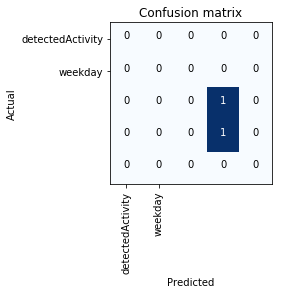

In [7]:
interp.plot_confusion_matrix()

KeyError: tensor(2)

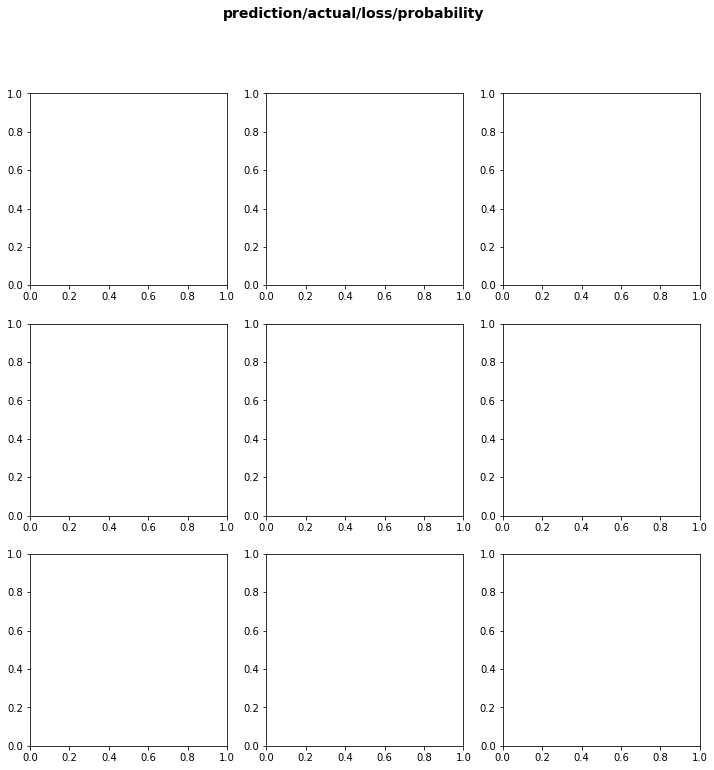

In [15]:
interp.plot_top_losses(9)